In [27]:
# pip install kagglehub

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
zip_path = "/content/archive.zip"
extract_path = "/content/fashion-pattern-images"

In [30]:
import zipfile
import os

# Create target directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/fashion-pattern-images")  # Change to `extract_path` if needed

# Optional: Check if extraction succeeded
if os.path.exists(extract_path):
    print(f" Extracted successfully to: {extract_path}")
else:
    print(" Extraction failed or folder name doesn't match.")

 Extracted successfully to: /content/fashion-pattern-images


In [33]:
import os
import shutil
import random

# Paths
original_dataset_dir = '/content/fashion-pattern-images/data_pattern'  # your extracted folder
base_dir = '/content/data'  # base path for train/val
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split ratio
split_ratio = 0.8  # 80% train, 20% val

# Split each class
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    images = os.listdir(class_path)
    random.shuffle(images)
    split_idx = int(len(images) * split_ratio)

    for image in images[:split_idx]:
        src = os.path.join(class_path, image)
        dst = os.path.join(train_dir, class_name, image)
        shutil.copyfile(src, dst)

    for image in images[split_idx:]:
        src = os.path.join(class_path, image)
        dst = os.path.join(val_dir, class_name, image)
        shutil.copyfile(src, dst)

print(" Dataset successfully split into train/ and val/")

 Dataset successfully split into train/ and val/


In [34]:
import os
from collections import Counter

dataset_dir = '/content/data/train'
class_counts = Counter()

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count

for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count} images")

animal: 346 images
cartoon: 256 images
data_pattern: 0 images
floral: 492 images
geometry: 336 images
ikat: 353 images
plain: 492 images
polka dot: 494 images
squares: 434 images
stripes: 498 images
tribal: 490 images


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4191 images belonging to 11 classes.
Found 2028 images belonging to 11 classes.


In [44]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(11, activation='softmax')(x)  # Changed from 19 to 11

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-44-3489286157.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

In [38]:
!mkdir -p "/content/fabric_model"

In [39]:
!ls best_model.keras

ls: cannot access 'best_model.keras': No such file or directory


In [40]:
model_save_path = '/content/fabric_model/best_model.keras'

In [41]:
model.save(model_save_path)
print("✅ Model saved to Google Drive successfully.")

✅ Model saved to Google Drive successfully.


In [42]:
from tensorflow.keras.models import load_model
model = load_model("/content/fabric_model/best_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [45]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_485']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2334 - loss: 2.2626

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_485']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


KeyboardInterrupt: 

In [46]:
model.save(model_save_path)
print("✅ Model saved to Google Drive successfully.")

✅ Model saved to Google Drive successfully.


In [50]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model("/content/fabric_model/best_model.keras")

# Class labels
class_labels = [
    "animal","cartoon","floral","geometry","ikat","plain","polka dot","squares","stripes","tribal"
]

# Load and preprocess image
img = image.load_img("/content/data/train/plain/113.jpg", target_size=(224, 224))  # Make sure size matches training
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0]  # shape: (19,)

# Print confidence scores for each class
print("\n📊 Confidence for all fabric patterns:")
for label, prob in zip(class_labels, prediction):
    print(f"{label:15s}: {prob * 100:.2f}%")

# Print top prediction
predicted_index = int(np.argmax(prediction))
print("\n✅ Most likely class:", class_labels[predicted_index])
print("🔍 Confidence:", round(prediction[predicted_index] * 100, 2), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

📊 Confidence for all fabric patterns:
animal         : 3.04%
cartoon        : 7.29%
floral         : 0.28%
geometry       : 3.26%
ikat           : 16.30%
plain          : 4.16%
polka dot      : 18.94%
squares        : 19.90%
stripes        : 15.28%
tribal         : 4.10%

✅ Most likely class: squares
🔍 Confidence: 19.9 %


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4191 images belonging to 11 classes.
Found 2028 images belonging to 11 classes.


In [58]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(11, activation='softmax')(x) # Change this line to 11

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-58-1861159460.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [53]:
!mkdir -p "/content/fabric_model"

In [54]:
model_save_path = '/content/fabric_model/best_model.keras'

In [55]:
model.save(model_save_path)
print("✅ Model saved to Google Drive successfully.")

✅ Model saved to Google Drive successfully.


In [56]:
from tensorflow.keras.models import load_model
model = load_model("/content/fabric_model/best_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [59]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2107']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2107']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2189 - loss: 2.3079

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2107']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


131/131 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.2195 - loss: 2.3058 - val_accuracy: 0.4906 - val_loss: 1.6403
Epoch 2/30
 90/131 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.4077 - loss: 1.7774

KeyboardInterrupt: 

In [60]:
model.save(model_save_path)
print("✅ Model saved to Google Drive successfully.")

✅ Model saved to Google Drive successfully.


In [62]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model("/content/fabric_model/best_model.keras")

# Class labels
class_labels = [
    "animal","cartoon","floral","geometry","ikat","plain","polka dot","squares","stripes","tribal"
]

# Load and preprocess image
img = image.load_img("/content/data/train/plain/113.jpg", target_size=(224, 224))  # Make sure size matches training
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0]  # shape: (19,)

# Print confidence scores for each class
print("\n📊 Confidence for all fabric patterns:")
for label, prob in zip(class_labels, prediction):
    print(f"{label:15s}: {prob * 100:.2f}%")

# Print top prediction
predicted_index = int(np.argmax(prediction))
print("\n✅ Most likely class:", class_labels[predicted_index])
print("🔍 Confidence:", round(prediction[predicted_index] * 100, 2), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

📊 Confidence for all fabric patterns:
animal         : 1.87%
cartoon        : 2.80%
floral         : 0.31%
geometry       : 6.25%
ikat           : 18.64%
plain          : 13.42%
polka dot      : 21.31%
squares        : 7.08%
stripes        : 7.85%
tribal         : 10.24%

✅ Most likely class: polka dot
🔍 Confidence: 21.31 %


In [63]:

model.trainable = True
# Optionally freeze the first few layers if needed:
for layer in model.layers[:100]:
    layer.trainable = False

# Recompile with a lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step


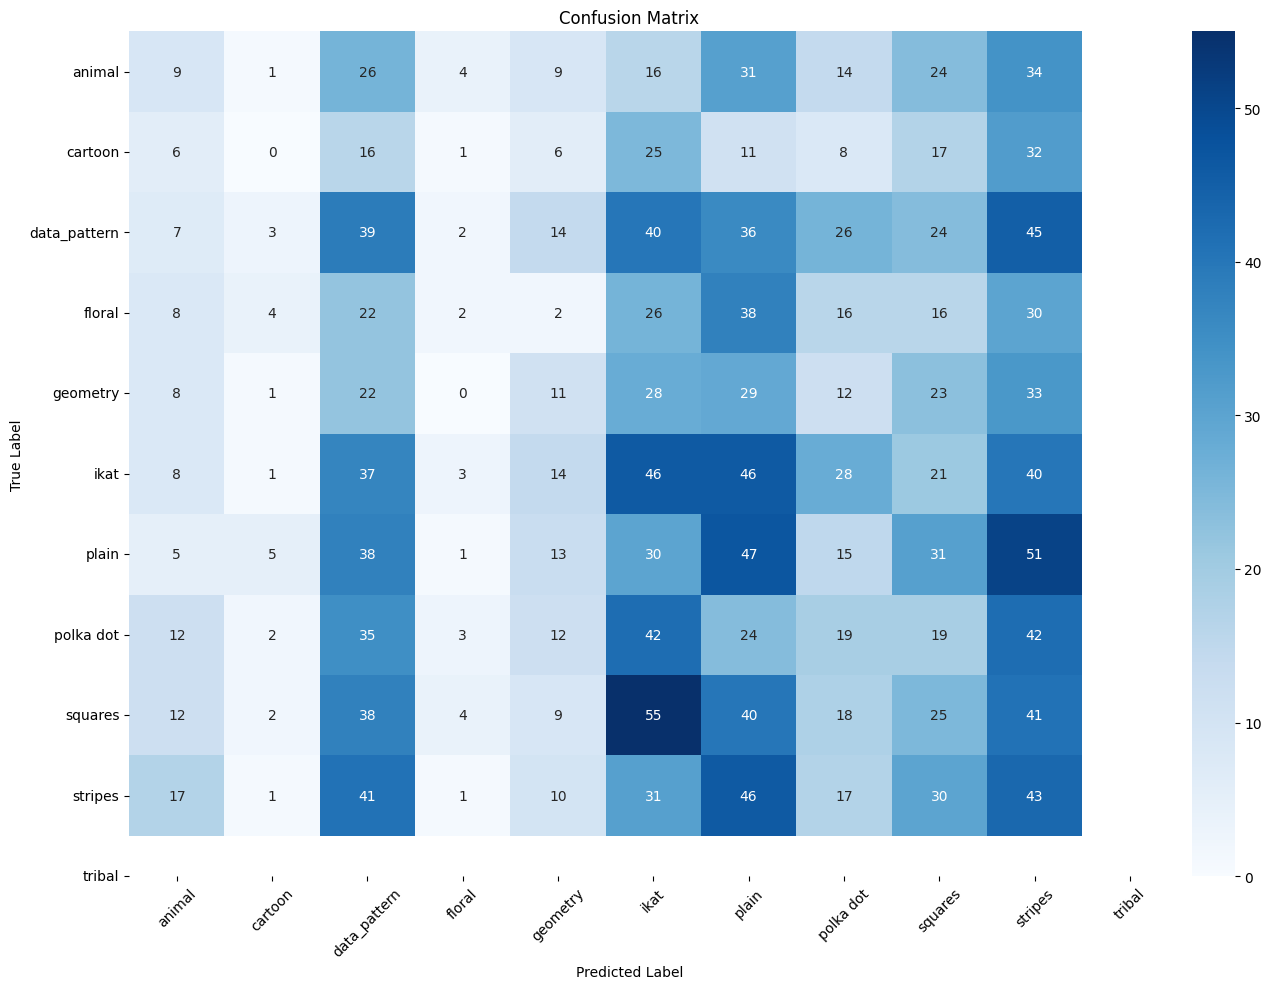

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assumes `model` is your trained model and `val_generator` is your validation data generator

# Get true labels and predictions
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())  # Get class label names

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()